# Fits

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
import pathlib
from glob import glob
from matplotlib.path import Path
from matplotlib.widgets import LassoSelector

mpl.rcParams.update(rcParams)

In [2]:
def load(filename: str):
    return pd.read_csv(filename, header=None)

In [3]:
class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

G1-anneau


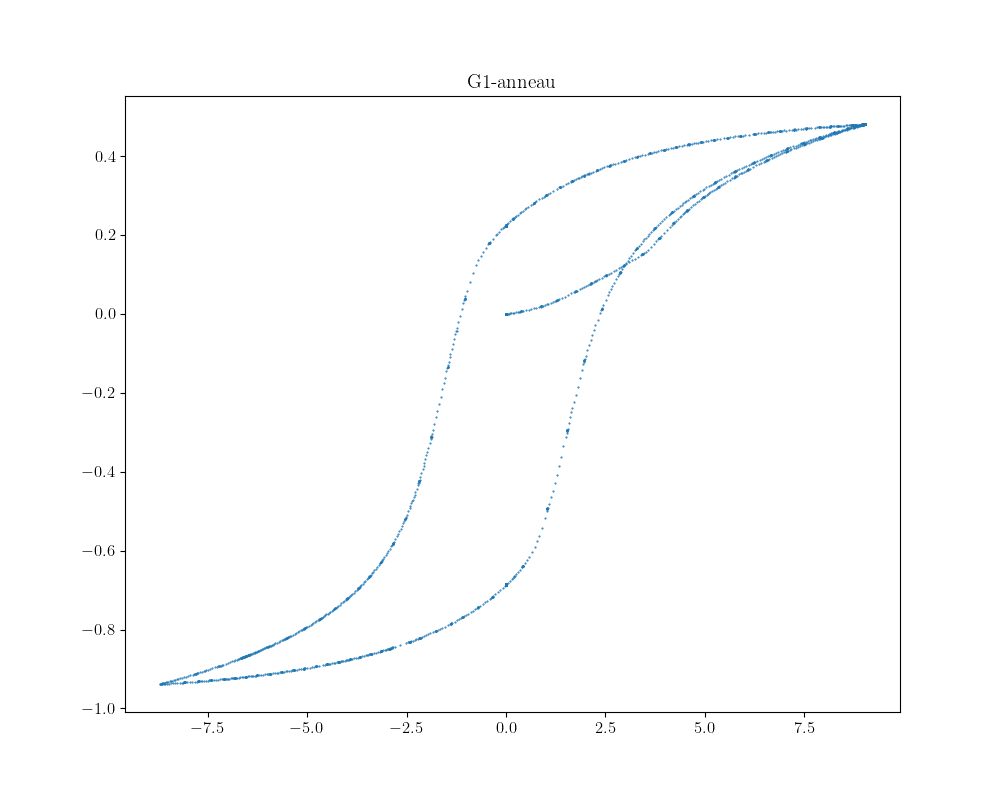

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
files = iter(glob("../data/*.csv"))
# Or give it a single file for faster updating
# files = iter(["../data/G1-cylindre-alu.csv"])
curr = None
fit_dict = {}

def plot(data) -> SelectFromCollection:
    pts = ax.scatter(data[0], data[1], marker=".", s=1, picker=5)
    selector = SelectFromCollection(ax, pts)
    return selector

selector = None
def load_next():
    global selector, curr
    try:
        file = next(files)
    except StopIteration:
        plt.close()
        return
    data = load(file)
    selector = plot(data)
    curr = pathlib.Path(file).stem
    print(curr)
    ax.set_title(curr)

def accept(event):
    global selector, curr
    if event.key == "enter":
        selected = selector.xys[selector.ind]
        coefs, cov = np.polyfit(selected[:,0], selected[:,1], 1, cov=True)
        coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))
        print("Fit: ({:.1ueP})x + ({:.1ueP})".format(*coefs_err))
        fit_dict.setdefault(curr, [])
        fit_dict[curr].append(coefs_err)
        # Show fit
        fit = np.poly1d(coefs)
        x = np.linspace(1.2 * np.min(selected[:,0]), 1.2 * np.max(selected[:,0]), 50)
        ax.plot(x, fit(x), color="red", linewidth=1)
        # selector.disconnect()
        # ax.set_title("")
        fig.canvas.draw()
    if event.key == "escape":
        selector.disconnect()
        plt.cla()
        load_next()
    

fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points.")
load_next()

In [ ]:
fit_dict

In [ ]:
with open('fits.csv', 'w+') as f:
    f.seek(0)
    f.write("# Nom, coef pente, ordonnée à l'origine\n")
    for key, value in fit_dict.items():
        avg = sum(value) / len(value)
        f.write(f"{key},{avg[0]},{avg[1]}\n")
    f.truncate()